In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from mnist import Net

# load pre-trained model
model = Net()
model.load_state_dict(torch.load("data/mnist_cnn.pt", map_location="cpu"))

# set model to evaluation mode
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

0%|          | 0/10 [00:00<?, ?it/s]

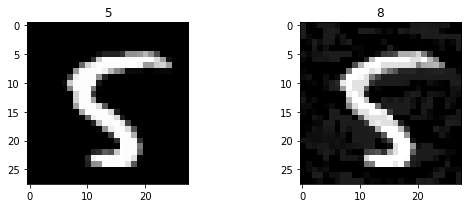

n_success 1 success_rate 0.50000:  20%|██        | 2/10 [00:14<00:48,  6.06s/it]

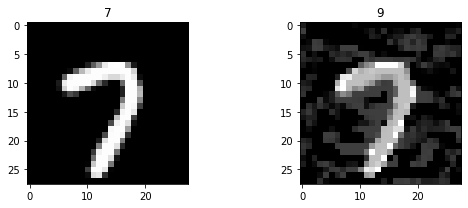

n_success 2 success_rate 0.66667:  30%|███       | 3/10 [00:20<00:42,  6.10s/it]

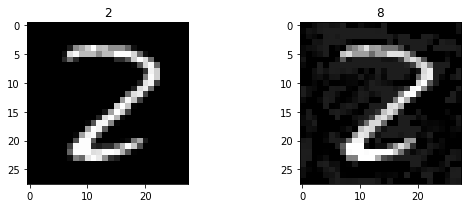

n_success 3 success_rate 0.75000:  40%|████      | 4/10 [00:24<00:31,  5.32s/it]

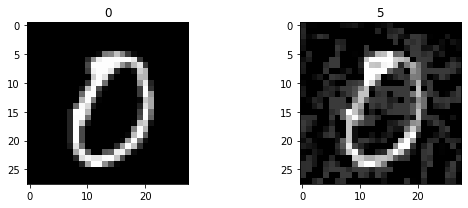

n_success 4 success_rate 0.66667:  60%|██████    | 6/10 [00:35<00:22,  5.52s/it]

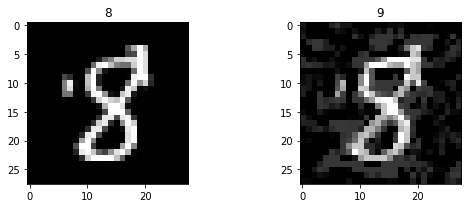

n_success 5 success_rate 0.71429:  70%|███████   | 7/10 [00:42<00:17,  5.98s/it]

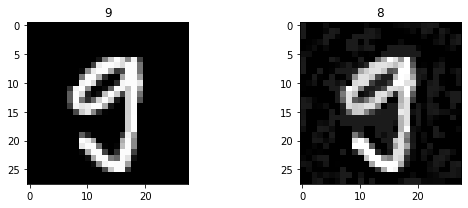

n_success 6 success_rate 0.75000:  80%|████████  | 8/10 [00:46<00:10,  5.38s/it]

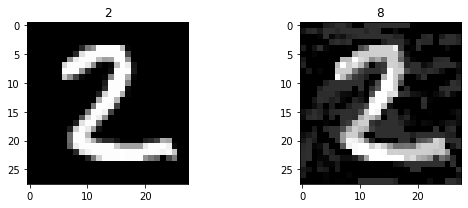

n_success 7 success_rate 0.77778:  90%|█████████ | 9/10 [00:52<00:05,  5.53s/it]

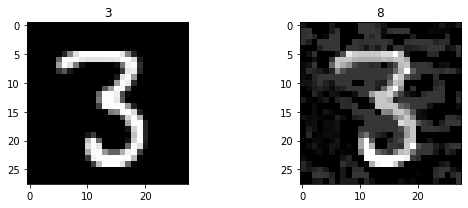

n_success 8 success_rate 0.80000: 100%|██████████| 10/10 [00:59<00:00,  5.92s/it]
success rate 0.8
avg queries 354.375



In [7]:
from tqdm import tqdm
from attacks import IFGSM
import data
import plot

loader = data.mnist(batch_size=1)

n_samples = 10
n_success = 0
success_rate = 0.0
t_count = 0
t_queries = 0
target=False

ifgsm = IFGSM(n_iter=500, epsilon=0.3, step_size=0.0005)

pbar = tqdm(total=n_samples)
for i, (x, y) in enumerate(loader):
    if target:
        torch.manual_seed(i)
        y_target = torch.randint(low=0, high=9, size=(1,))
        while y_target == y:
            y_target = torch.randint(low=0, high=9, size=(1,))

        success, n_queries, adv, y_hat = ifgsm.attack(model, x, y_target, target=target)
    else:
        success, n_queries, adv, y_hat = ifgsm.attack(model, x, y)

    # if success:
    #     plot.images(x.squeeze(), y, adv.squeeze().detach(), y_hat)
    
    if success:
        t_queries += n_queries
        n_success += 1

    success_rate = n_success / (i + 1)
    pbar.set_description("n_success %d success_rate %.5f" % (n_success, success_rate))
    pbar.update(1)
    t_count += 1
    if t_count == n_samples:
        break
pbar.close()

success_rate = n_success / n_samples
print("\nsuccess rate", success_rate)
print("avg queries", t_queries / n_success)